In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
from fsl_experiment_suite import Path

In [3]:
from fsl_experiment_suite.data.utils import load_evs, EXPERIMENTS
from fsl_experiment_suite.data.core import get_events

In [4]:
import nilearn
import nibabel as nib
from nilearn import plotting, image, masking, datasets, input_data
from nilearn.plotting import plot_anat, plot_img, plot_stat_map, plot_prob_atlas

/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# Getting the data

In [5]:
DATA_DIR = Path("/home/anukoolpurohit/Documents/AnukoolPurohit/Datasets/fslcourse/fslcourse_data")

In [6]:
experiment = "parametric"
parametric_stimulus_data = load_evs(experiment)
TR = EXPERIMENTS[experiment]['TR']

In [7]:
fmri_img = nib.load(DATA_DIR/"parametric"/"fmri_data.nii.gz")
fmri_img.uncache()

In [8]:
print(fmri_img.shape)

(91, 109, 91, 1100)


# Encoding Experiment

## Remove Background

In [9]:
background_mask = masking.compute_brain_mask(fmri_img)
fmri_img.uncache()

In [10]:
fmri_without_background = masking.apply_mask(fmri_img, background_mask)
fmri_img.uncache()

In [11]:
fmri_without_background.shape

(1100, 229007)

## Accounting for the HR

In [12]:
from nilearn.glm.first_level.hemodynamic_models import _gamma_difference_hrf

In [13]:
nilearn.glm.first_level.glover_hrf??

In [14]:
# HRF = nilearn.glm.first_level.glover_hrf(tr=TR, time_length=16, oversampling=1, onset=0)

In [15]:
tr=TR 
time_length=20
oversampling=1
onset=0
HRF = _gamma_difference_hrf(tr, oversampling, time_length, onset,
                                 delay=4, undershoot=12., dispersion=.9,
                                 u_dispersion=.9, ratio=.35)

In [16]:
HRF.shape

(21,)

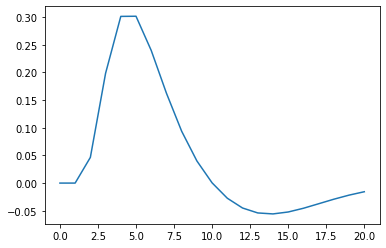

In [17]:
plt.plot(HRF)

In [18]:
n   = len(parametric_stimulus_data['WPM_0050'])
data_wpm_0050 = np.convolve(parametric_stimulus_data['WPM_0050'],HRF,'full')[:n]
data_wpm_0350 = np.convolve(parametric_stimulus_data['WPM_0350'],HRF,'full')[:n]
data_wpm_0650 = np.convolve(parametric_stimulus_data['WPM_0650'],HRF,'full')[:n]
data_wpm_0950 = np.convolve(parametric_stimulus_data['WPM_0950'],HRF,'full')[:n]
data_wpm_1250 = np.convolve(parametric_stimulus_data['WPM_1250'],HRF,'full')[:n]

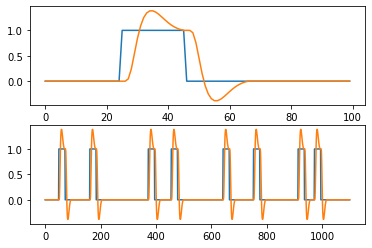

In [95]:
# plot the new EVs:
fig, a = plt.subplots(2, 1)
a[0].plot(parametric_stimulus_data['WPM_0050'][:100])
a[0].plot(data_wpm_0050[:100])

a[1].plot(parametric_stimulus_data['WPM_0350'])
a[1].plot(data_wpm_0350)

## Design Matrix

In [20]:
data_wpm = [data_wpm_0050, data_wpm_0350, data_wpm_0650, data_wpm_0950, data_wpm_1250]
mean_subtracted_data = [dt - np.mean(dt) for dt in data_wpm]
design_matrix = np.asarray(mean_subtracted_data +[np.ones_like(mean_subtracted_data[0])]).T

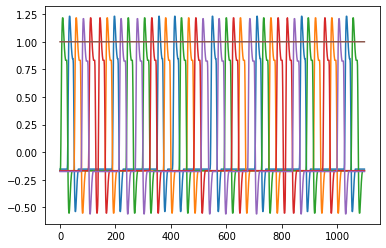

In [21]:
plt.plot(design_matrix)

## HRF Experiments

In [22]:
import numpy as np
frame_times = np.linspace(0, 30, 61)
onset, amplitude, duration = 0., 1., 1.
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

In [23]:
stim = np.zeros_like(frame_times)
stim[(frame_times > onset) * (frame_times <= onset + duration)] = amplitude



In [24]:
hrf_models = [None, 'glover + derivative', 'glover + derivative + dispersion']

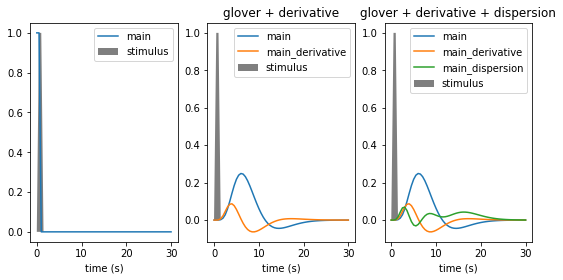

In [25]:
from nilearn.glm.first_level import compute_regressor
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 4))
for i, hrf_model in enumerate(hrf_models):
    # obtain the signal of interest by convolution
    signal, name = compute_regressor(
        exp_condition, hrf_model, frame_times, con_id='main',
        oversampling=16)

    # plot this
    plt.subplot(1, 3, i + 1)
    plt.fill(frame_times, stim, 'k', alpha=.5, label='stimulus')
    for j in range(signal.shape[1]):
        plt.plot(frame_times, signal.T[j], label=name[j])
    plt.xlabel('time (s)')
    plt.legend(loc=1)
    plt.title(hrf_model)

# adjust the plot
plt.subplots_adjust(bottom=.12)
plt.show()

## continue GLM

In [26]:
from fsl_experiment_suite.glm import glm

In [27]:
mask_glm = np.ones_like(fmri_without_background[0])>0
beta, t = glm(Y=fmri_without_background, X=design_matrix, mask = mask_glm)
t_fmri = masking.unmask(t, background_mask)
beta_fmri = masking.unmask(beta, background_mask)

/home/anukoolpurohit/Documents/Workspace/Nueromatch/FSLexperiments/fsl_experiment_suite/glm.py:41: RuntimeWarning: invalid value encountered in true_divide
  tstat[:,mask] = cope[:,mask] / np.sqrt(varcope[:,mask])


### Alternate GLM

In [28]:
# from scipy import stats
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model = model.fit(design_matrix, fmri_without_background)
# model.coef_.shape
# design_matrix.shape

# tstat   = np.zeros_like(model.coef_)
# r = fmri_without_background - (design_matrix@(model.coef_.T))
# dof  = design_matrix.shape[0] - np.linalg.matrix_rank(design_matrix)
# sig2 = np.sum(r**2,axis=0)/dof
# varcope = np.outer(np.diag(np.linalg.inv(design_matrix.T@design_matrix)),sig2)
# tstat = model.coef_.T / np.sqrt(varcope)

# tstat.shape

# t_fmri = masking.unmask(tstat, background_mask)

## Plot T-scores

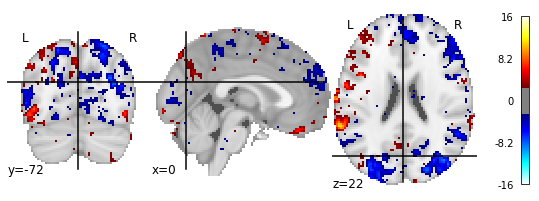

In [69]:
plot_stat_map(image.index_img(t_fmri, 0), threshold=2.5)


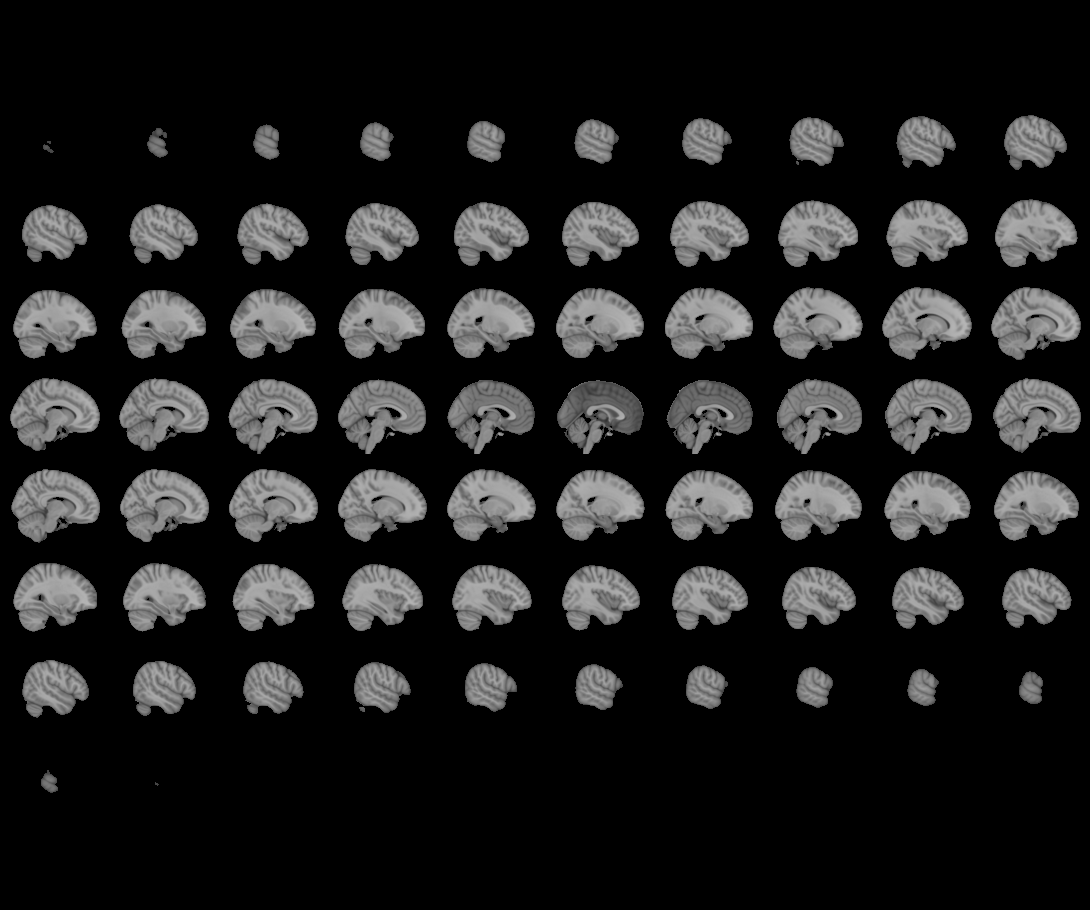
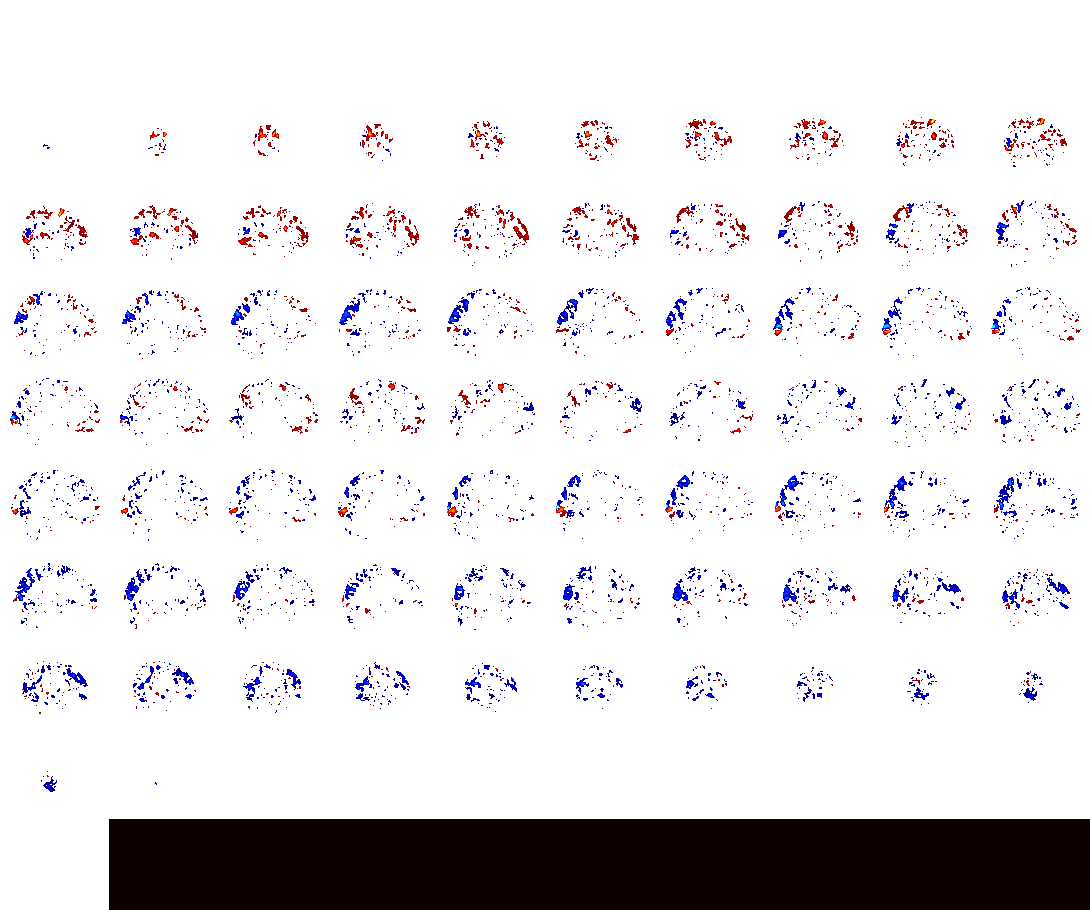

In [73]:
# 50 WPM
plotting.view_img(image.index_img(t_fmri, 0), threshold=2.5)

In [31]:
print(list(parametric_stimulus_data.keys()))

['WPM_0050', 'WPM_0350', 'WPM_0650', 'WPM_0950', 'WPM_1250']



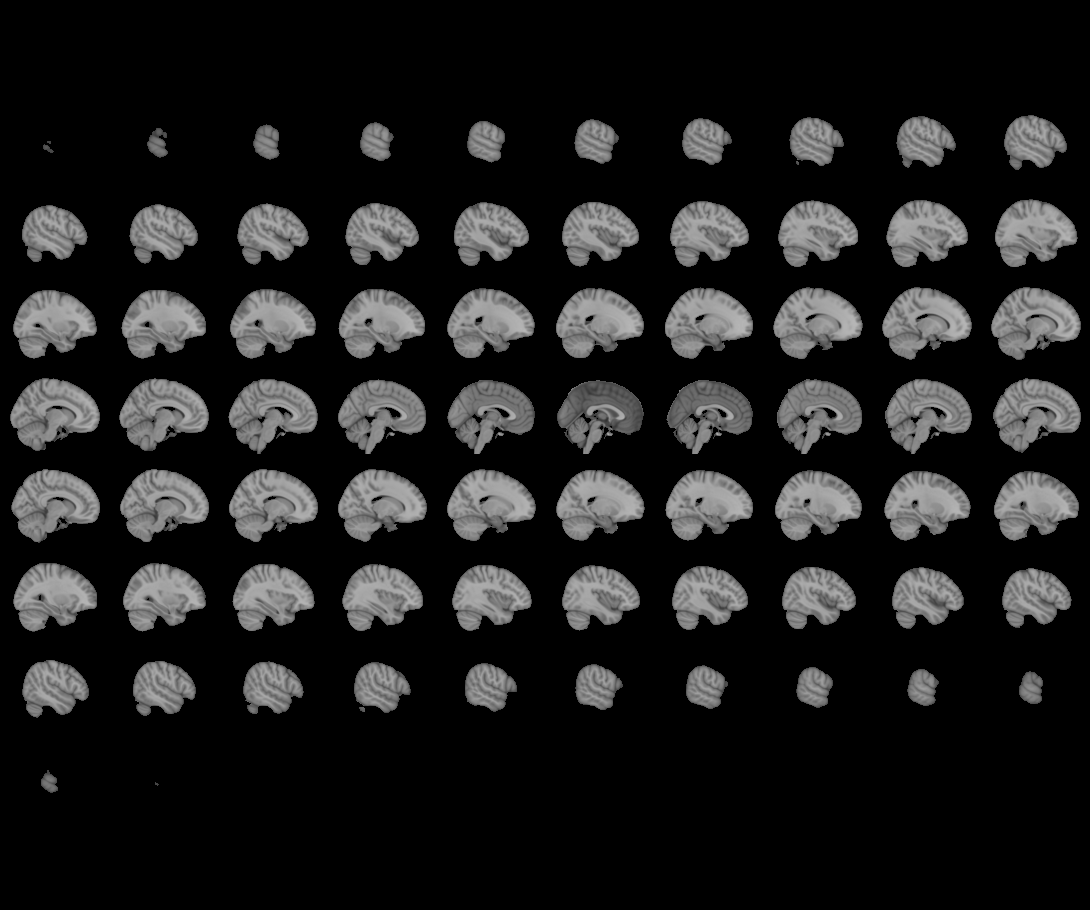
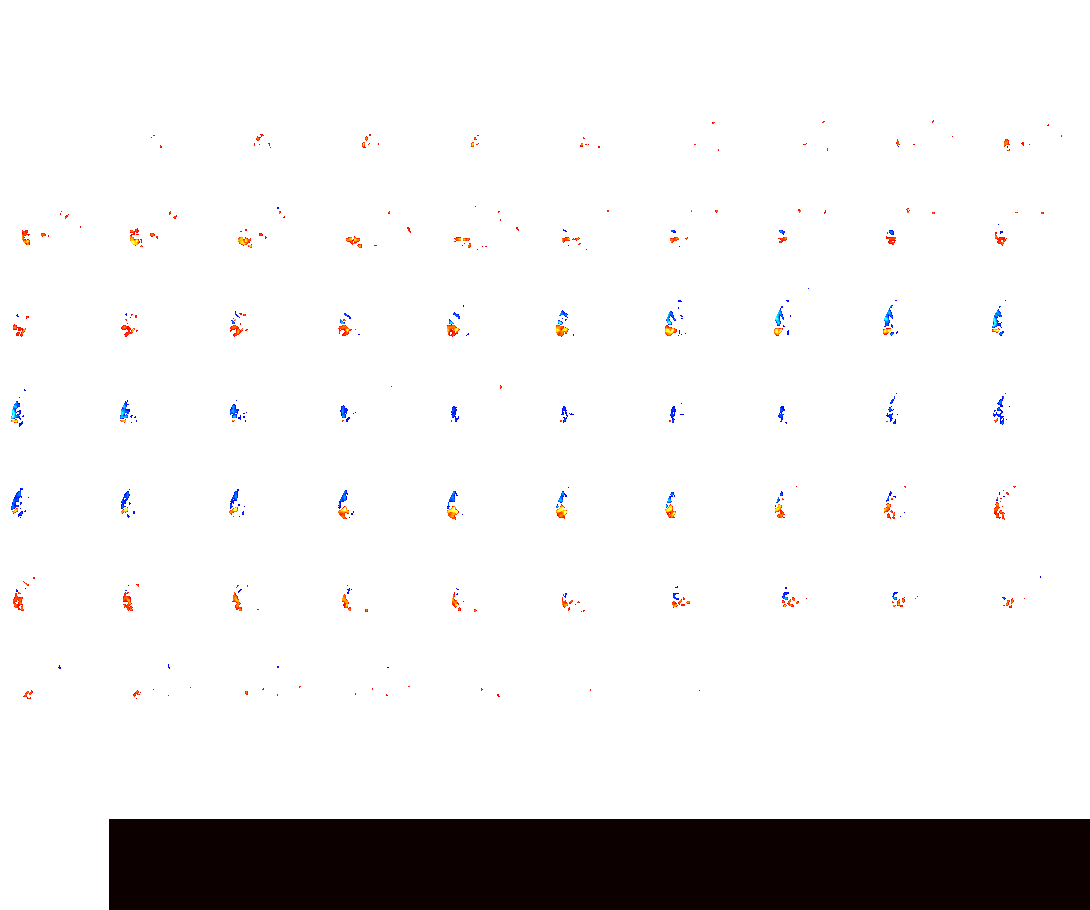

In [71]:
# 650 WP<
plotting.view_img(image.index_img(t_fmri, 2), threshold=10)

In [33]:
# nilearn.image.index_img(fmri_img, [1:25]).shape


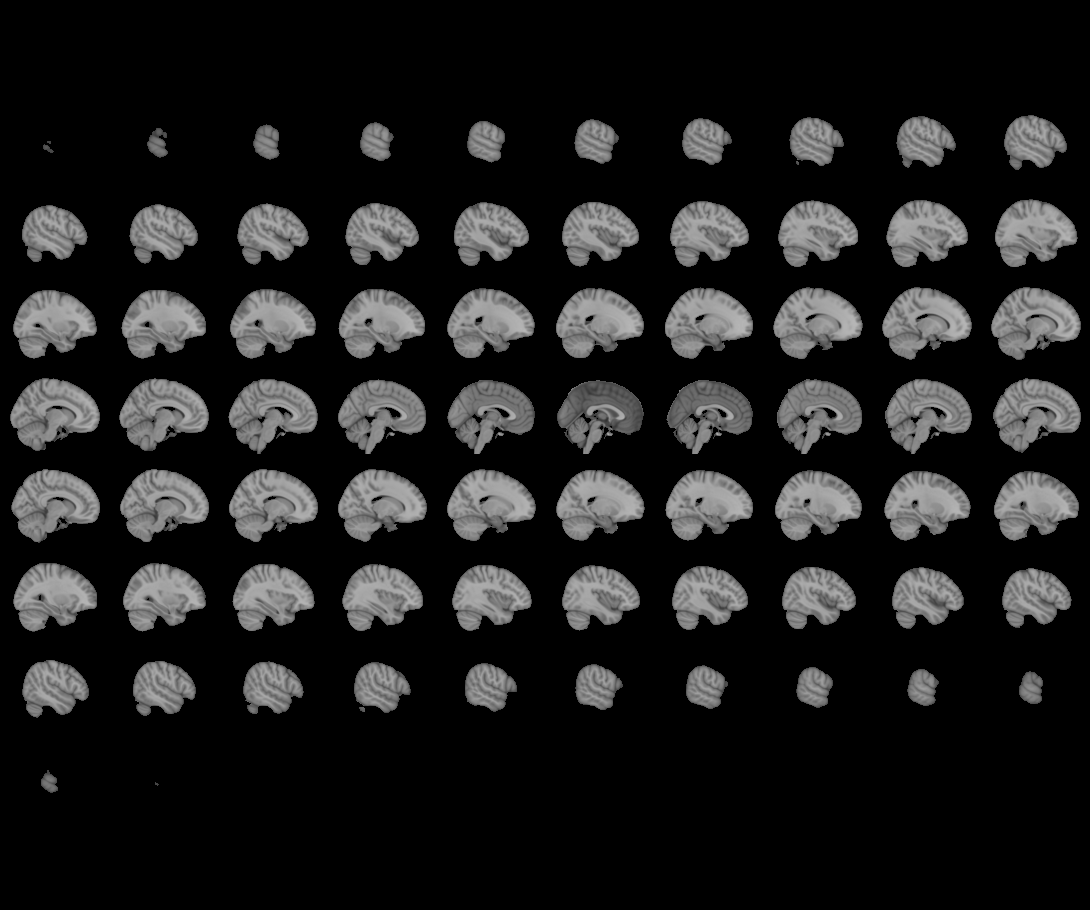
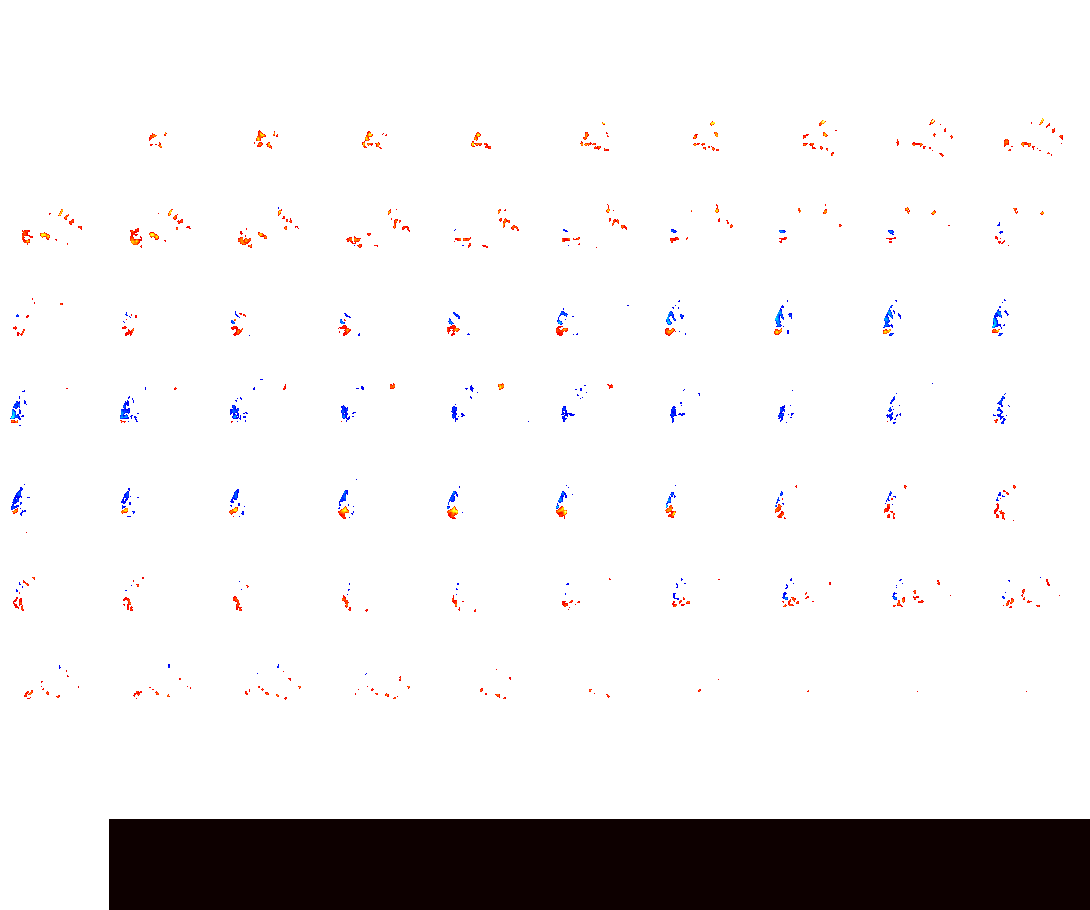

In [72]:
plotting.view_img(image.index_img(t_fmri, 4), threshold=10)

# Exploring Harvard-Oxford Atlas

In [35]:
from nilearn.datasets import fetch_atlas_harvard_oxford

In [36]:
atlas = fetch_atlas_harvard_oxford("cort-prob-2mm")

In [37]:
for i, label in enumerate(atlas.labels):
    print(f"Label {i}: {label}")

Label 0: Background
Label 1: Frontal Pole
Label 2: Insular Cortex
Label 3: Superior Frontal Gyrus
Label 4: Middle Frontal Gyrus
Label 5: Inferior Frontal Gyrus, pars triangularis
Label 6: Inferior Frontal Gyrus, pars opercularis
Label 7: Precentral Gyrus
Label 8: Temporal Pole
Label 9: Superior Temporal Gyrus, anterior division
Label 10: Superior Temporal Gyrus, posterior division
Label 11: Middle Temporal Gyrus, anterior division
Label 12: Middle Temporal Gyrus, posterior division
Label 13: Middle Temporal Gyrus, temporooccipital part
Label 14: Inferior Temporal Gyrus, anterior division
Label 15: Inferior Temporal Gyrus, posterior division
Label 16: Inferior Temporal Gyrus, temporooccipital part
Label 17: Postcentral Gyrus
Label 18: Superior Parietal Lobule
Label 19: Supramarginal Gyrus, anterior division
Label 20: Supramarginal Gyrus, posterior division
Label 21: Angular Gyrus
Label 22: Lateral Occipital Cortex, superior division
Label 23: Lateral Occipital Cortex, inferior division


In [38]:
atlas_map = nib.load(atlas.maps)

In [39]:
atlas_map.shape

(91, 109, 91, 48)

/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/plotting/displays.py:101: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


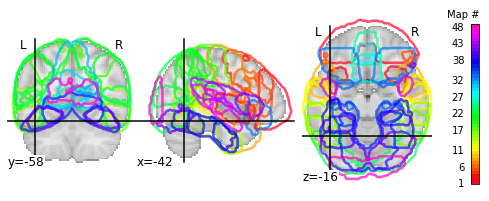

In [40]:
plot_prob_atlas(atlas_map, cut_coords=(-42, -58, -16), colorbar=True, threshold=1)

# Playing with T- stats

In [41]:
mask_glm.shape

(229007,)

In [76]:
dummy = np.array([.5, 1 , 5, 1, .5])
dummy = dummy[None, :]
print(t[:5].shape, dummy.shape)

(5, 229007) (1, 5)


In [63]:
beta_dummy, dummy_t = glm(t[:5], dummy.T,  mask=mask_glm)

In [64]:
dummy_t.shape

(1, 229007)

/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



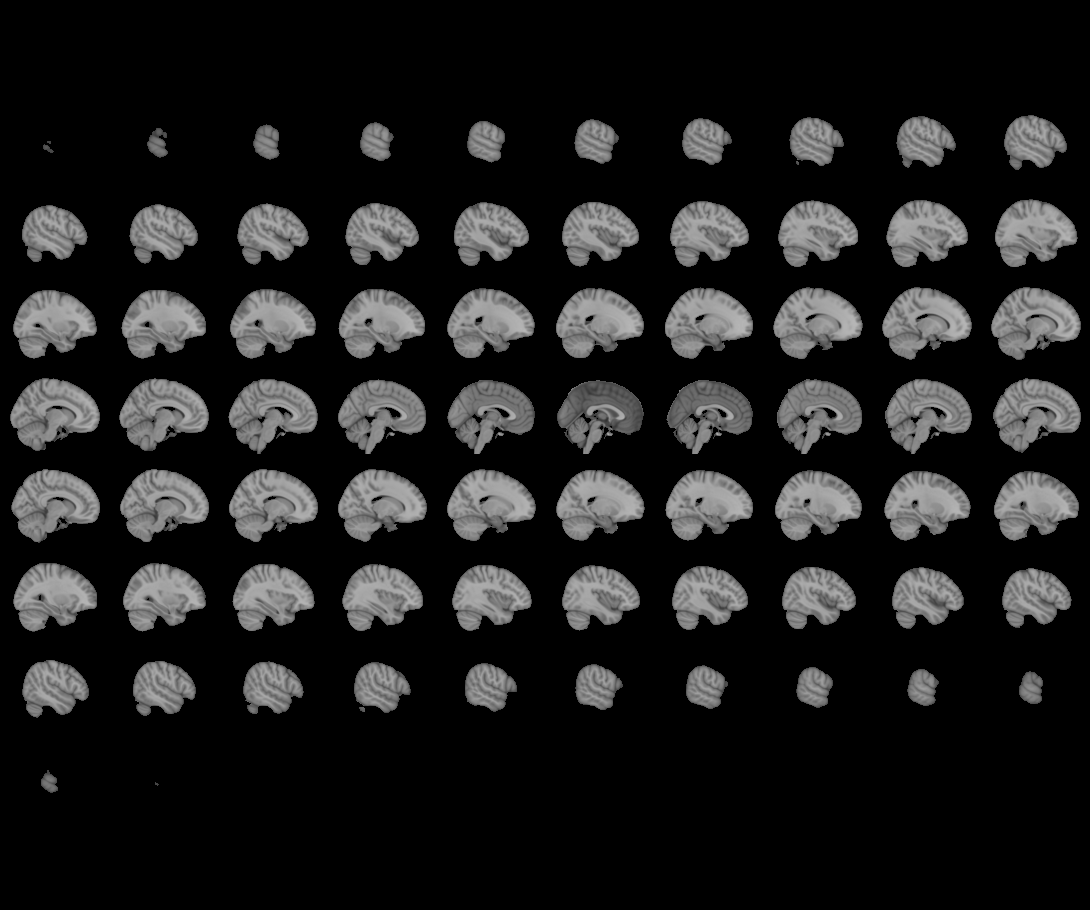
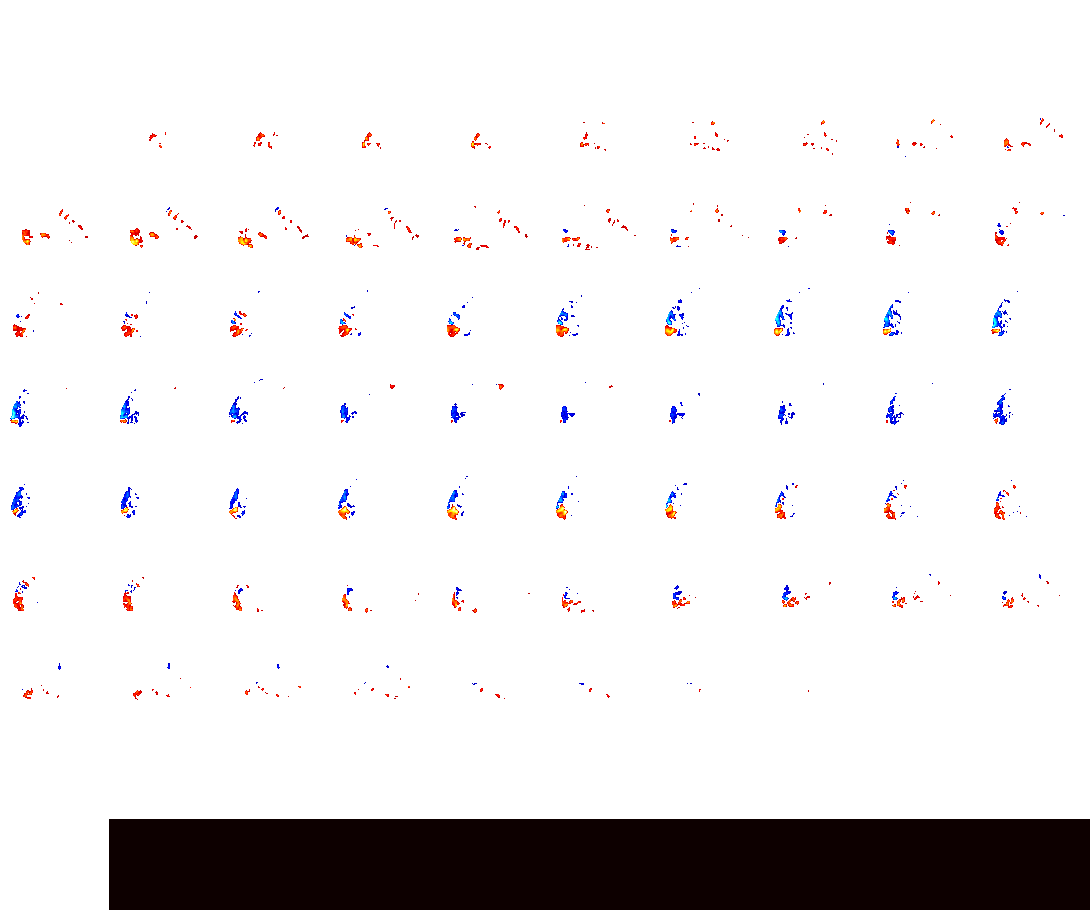

In [77]:
dummy_t = (dummy @ t[:5,:])
(dummy_t[None, :]).shape
dummy_t_fmri = masking.unmask(beta_dummy, background_mask)
plotting.view_img(dummy_t_fmri, threshold=2.0)

# Plotting Regions in the atlas

In [48]:
from nilearn.input_data import NiftiMapsMasker

In [49]:
masker = NiftiMapsMasker(maps_img=atlas_map, standardize=False, memory="nilearn_cache", verbose=5)

In [50]:
time_series = masker.fit_transform(image.index_img(t_fmri, slice(0, 5)))

[NiftiMapsMasker.fit_transform] loading regions from Nifti1Image('/home/anukoolpurohit/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-prob-2mm.nii.gz')


/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/image/image.py:1054: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/_utils/cache_mixin.py:303: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7fe9dbf115b0>, <nilearn.input_data.nifti_maps_masker._ExtractionFunctor object at 0x7fe9e04be880>, 
{ 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'low_pass': None,
  'maps_img': <nibabel.nifti1.Nifti1Image object at 0x7fe9e04be5e0>,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': False,
  'standardize_confounds': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=5)
[NiftiMapsMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(91, 109, 91, 5),
affine=array([[  -2.,    0.,    0.,   90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0

/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


[NiftiMapsMasker.transform_single_imgs] Cleaning extracted signals
_______________________________________________filter_and_extract - 3.7s, 0.1min


/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/input_data/nifti_maps_masker.py:348: UserWarning: Persisting input arguments took 0.95s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  region_signals, labels_ = self._cache(


In [51]:
time_series.shape

(5, 48)

In [52]:
list(time_series[:, 23])

[-0.02366995648866711,
 -0.09761970528194727,
 -0.10110976649140069,
 -0.08579950953190742,
 -0.10580501760764663]

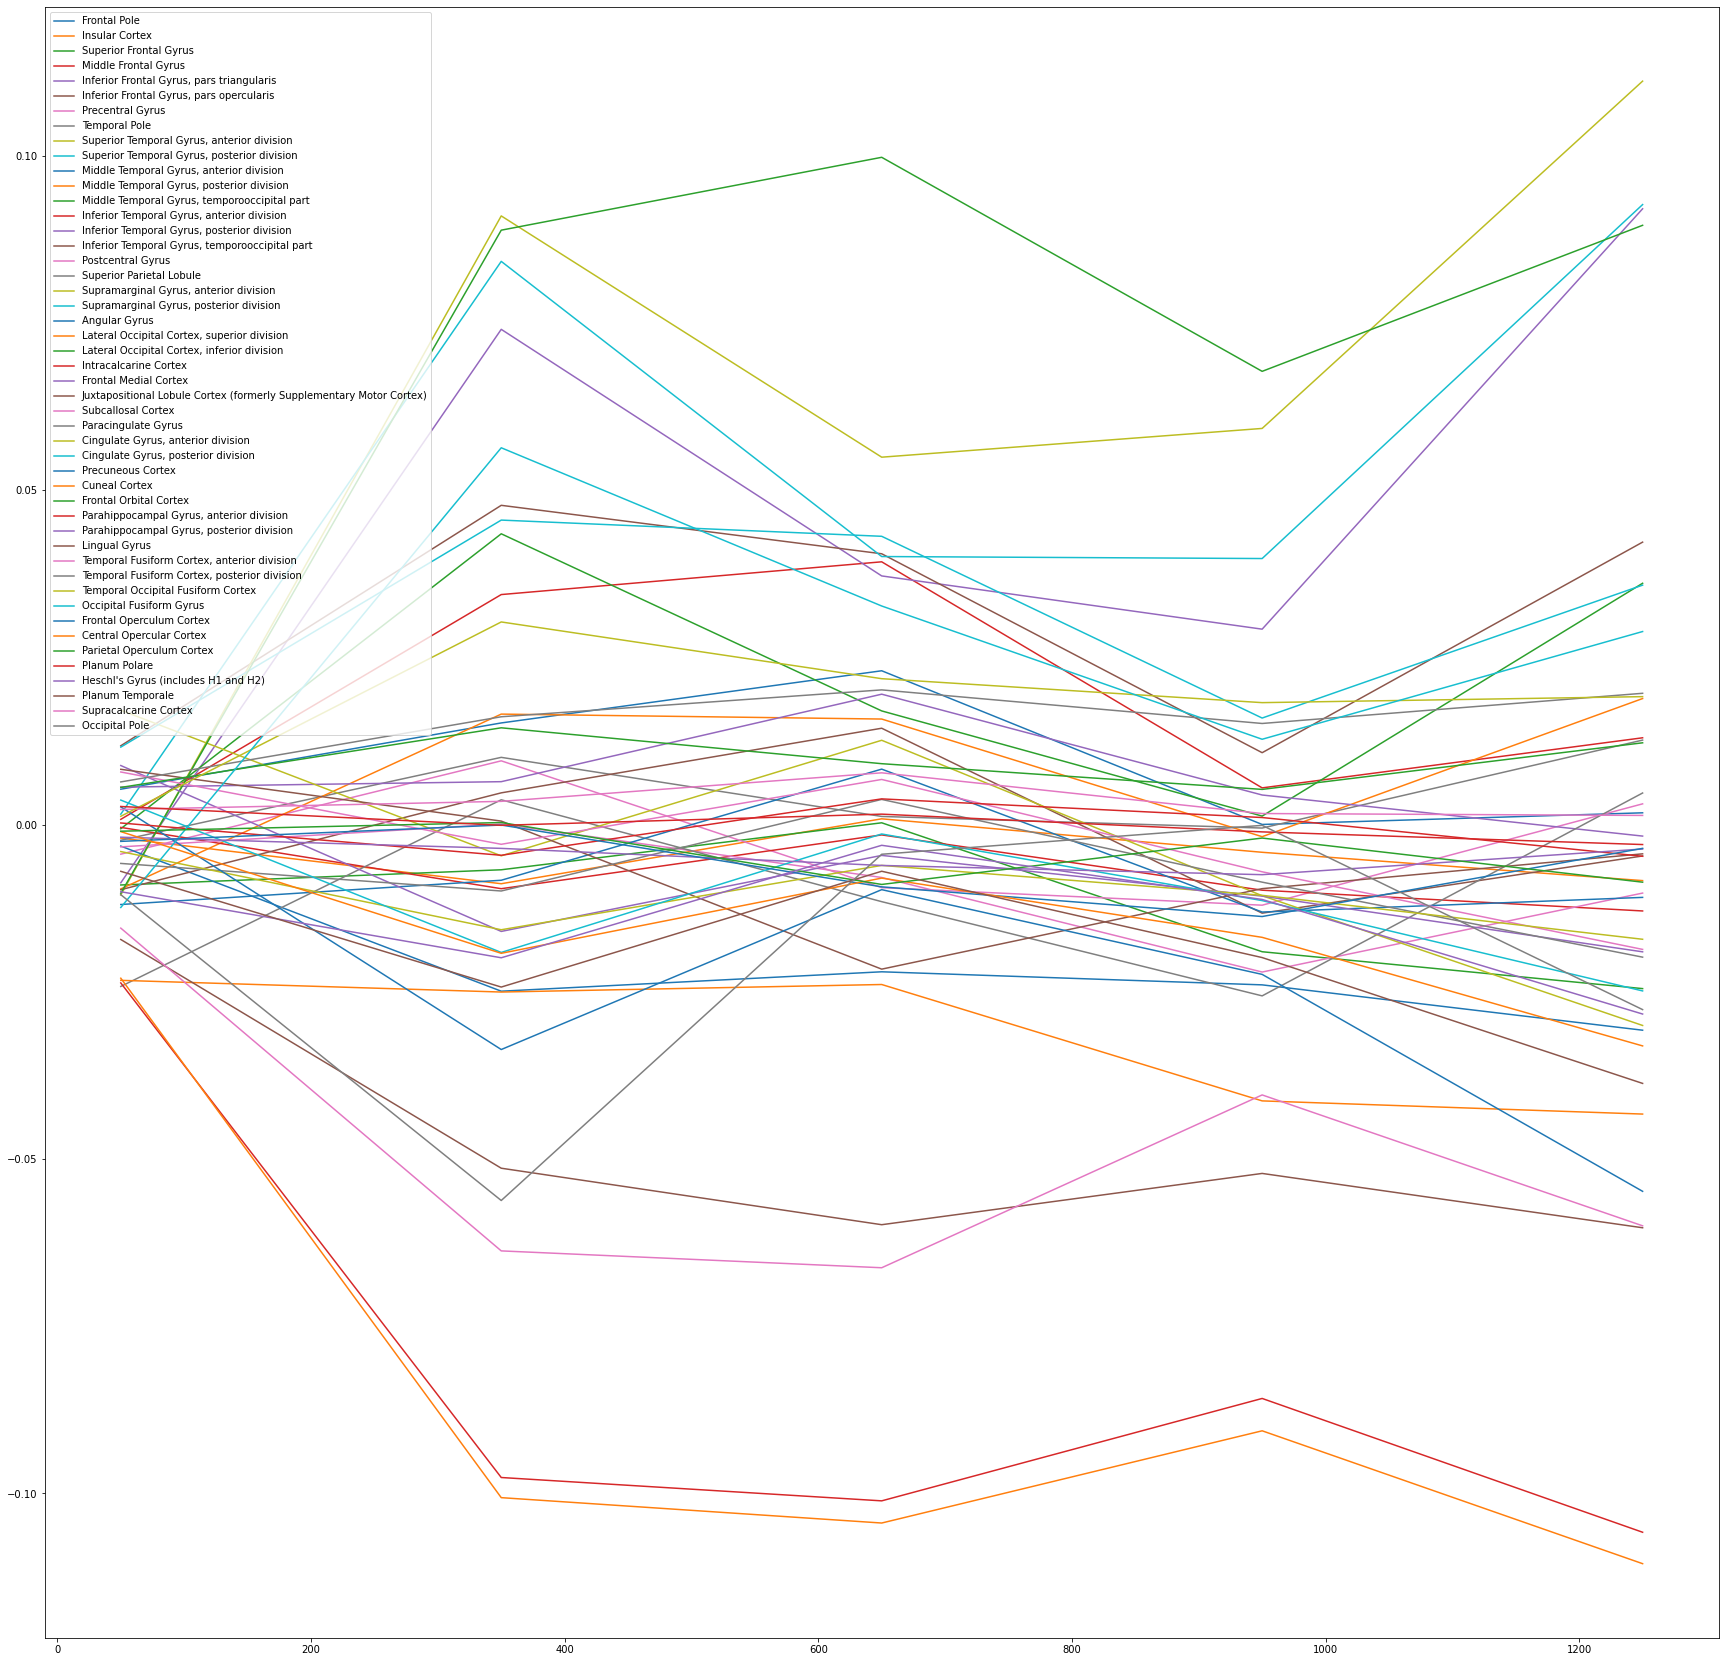

In [53]:
fig = plt.figure(figsize=(30, 30))
plt.plot([50, 350, 650, 950, 1250], time_series)
plt.legend(atlas.labels[1:])

# Region Extraction

In [80]:
for i, label in enumerate(atlas.labels):
    print(f"Label {i}: {label}")

Label 0: Background
Label 1: Frontal Pole
Label 2: Insular Cortex
Label 3: Superior Frontal Gyrus
Label 4: Middle Frontal Gyrus
Label 5: Inferior Frontal Gyrus, pars triangularis
Label 6: Inferior Frontal Gyrus, pars opercularis
Label 7: Precentral Gyrus
Label 8: Temporal Pole
Label 9: Superior Temporal Gyrus, anterior division
Label 10: Superior Temporal Gyrus, posterior division
Label 11: Middle Temporal Gyrus, anterior division
Label 12: Middle Temporal Gyrus, posterior division
Label 13: Middle Temporal Gyrus, temporooccipital part
Label 14: Inferior Temporal Gyrus, anterior division
Label 15: Inferior Temporal Gyrus, posterior division
Label 16: Inferior Temporal Gyrus, temporooccipital part
Label 17: Postcentral Gyrus
Label 18: Superior Parietal Lobule
Label 19: Supramarginal Gyrus, anterior division
Label 20: Supramarginal Gyrus, posterior division
Label 21: Angular Gyrus
Label 22: Lateral Occipital Cortex, superior division
Label 23: Lateral Occipital Cortex, inferior division


In [82]:
atlas_map.shape

(91, 109, 91, 48)

In [84]:
ofg_map = image.index_img(atlas_map, 22)

In [89]:
map_data = ofg_map.dataobj

In [92]:
map_data = (map_data > 0)

/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



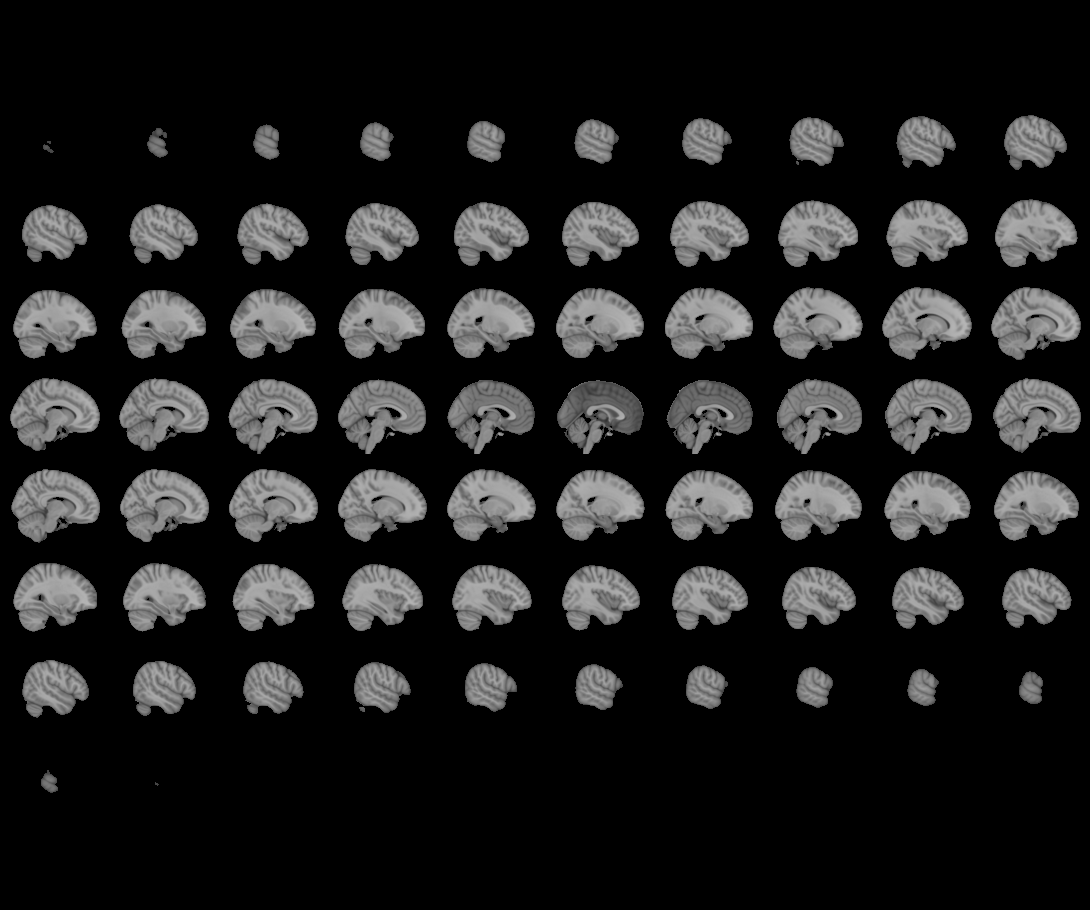
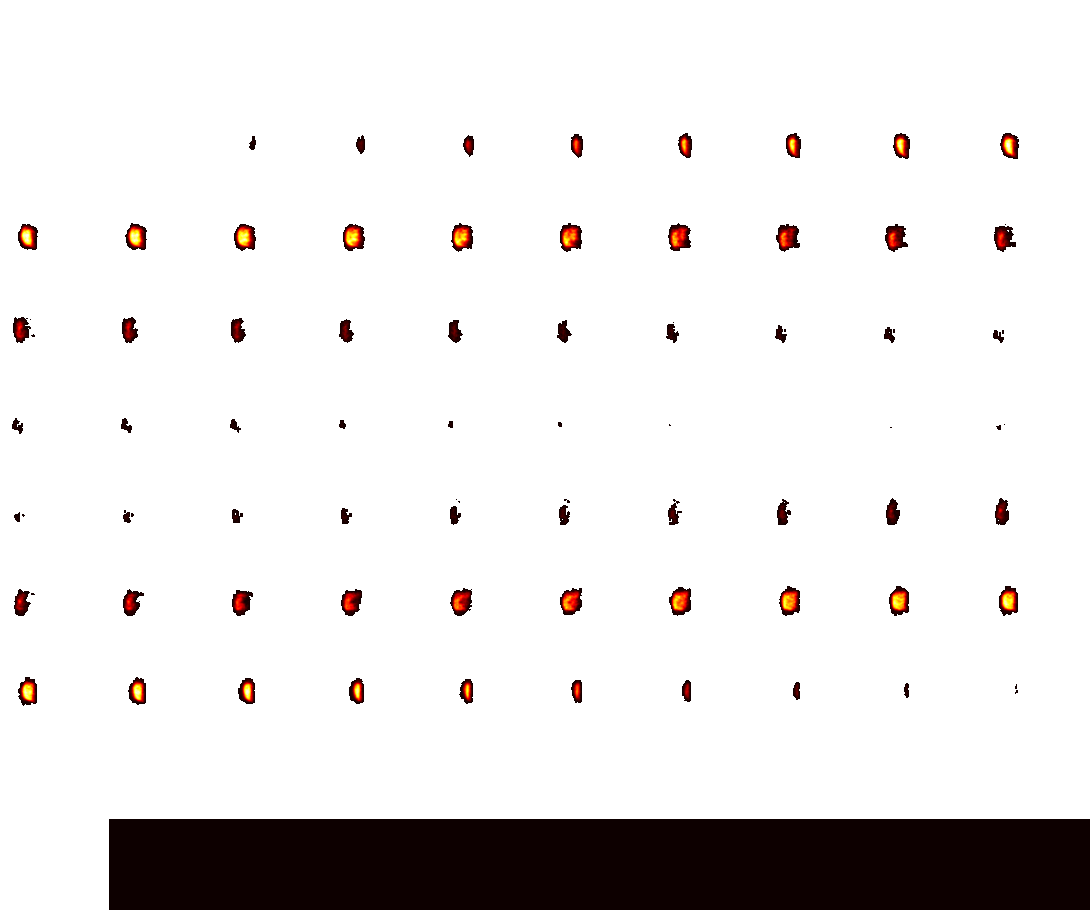

In [85]:
plotting.view_img(ofg_map)

In [96]:
ofg_mask = image.new_img_like(fmri_img, map_data)

In [97]:
ofg_mask.shape

(91, 109, 91)

/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "
/home/anukoolpurohit/anaconda3/envs/FSL/lib/python3.9/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



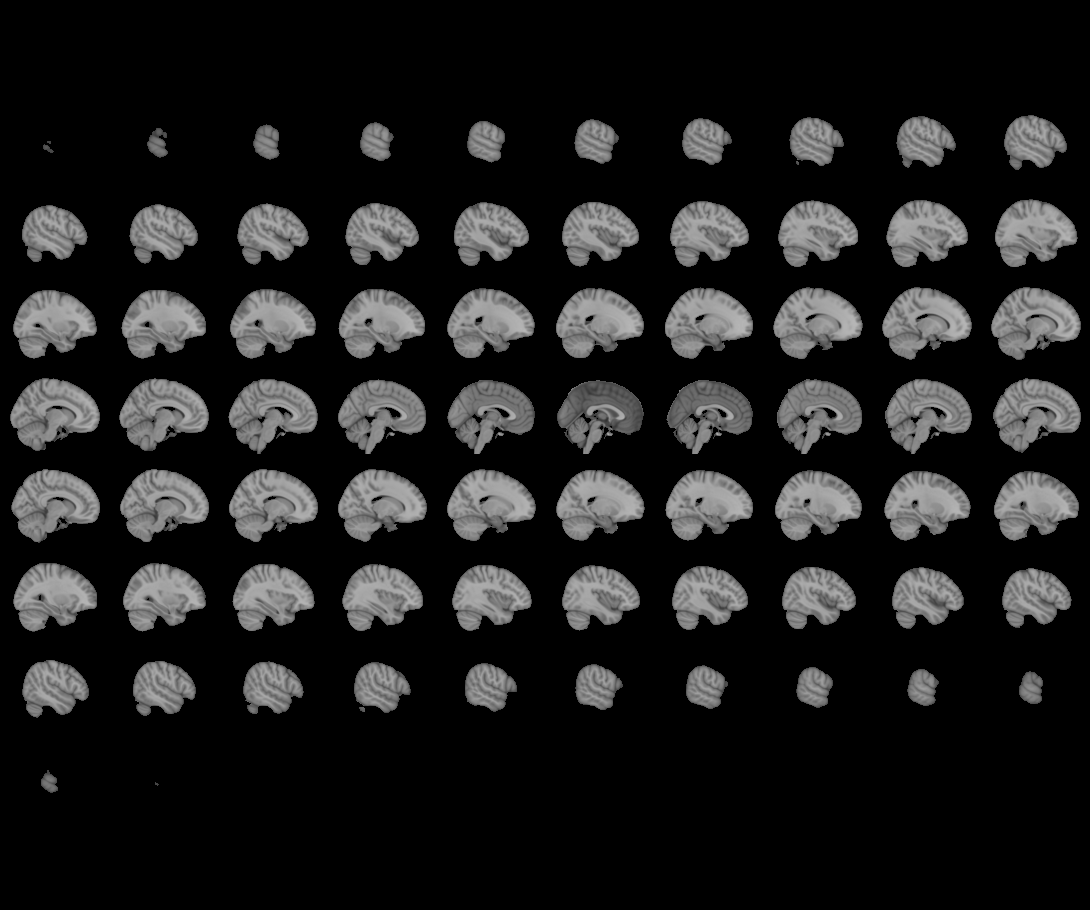
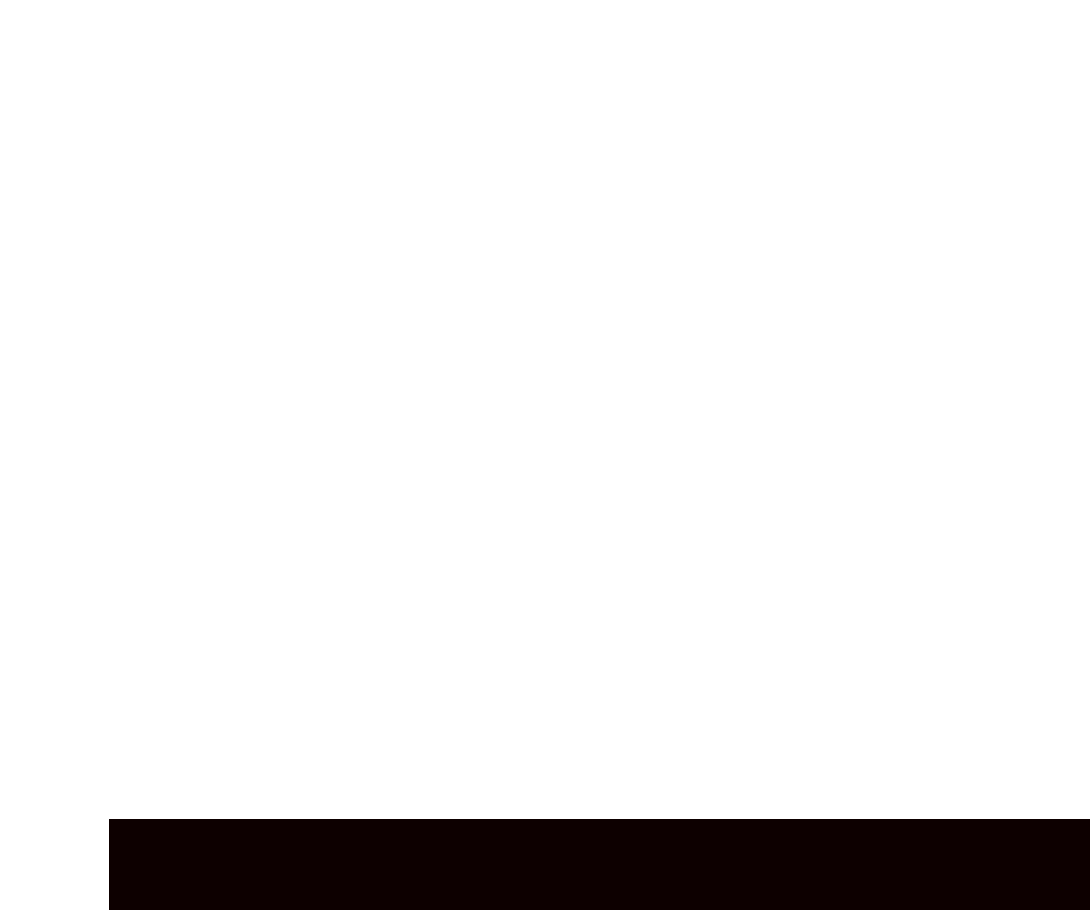

In [98]:
plotting.view_img(ofg_mask)

In [99]:
masked_ofg = masking.apply_mask(fmri_img, ofg_mask)

In [100]:
masked_ofg.shape

(1100, 17294)